# Face Identification Classifier

### Ref https://github.com/peteryuX/arcface-tf2

In [1]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from models import ArcFaceModel
# from losses import SoftmaxLoss
from losses import softmax_loss
import dataset
import tensorflow as tf
import os
import logging

tf.get_logger().setLevel(logging.ERROR)
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
!echo $CUDA_VISIBLE_DEVICES

0


In [3]:
### IJB-C Dataset

# batch_size = 128
# input_size = 112
# embd_shape = 512
# head_type = 'ArcHead'
# backbone_type = 'MobileNetV2'
# w_decay=5e-4
# num_classes = 3584 
# base_lr = 0.01
# dataset_len = 13033 
# epochs = 100
# steps_per_epoch = dataset_len // batch_size

### MS1M dataset

batch_size = 128 # Initially 128
input_size = 112
embd_shape = 512
head_type = 'ArcHead'
backbone_type = 'MobileNetV2'
w_decay=5e-4
num_classes = 85742 
dataset_len = 5822653 
base_lr = 0.01 # initially 0.01
epochs = 20
save_steps = 1000
steps_per_epoch = dataset_len // batch_size
steps = 1
is_ccrop=False
binary_img=True
is_Adam = False

### Find latest checkpoint

In [4]:
from glob import glob
base_dir = "/hd/jbpark/models/checkpoints/"
save_name = "e*"
file_list = []
for files in glob(base_dir+save_name):
    file_list.append(files.split('/')[-1].split('l_')[-1])
file_list.sort()

load_file_name = []
for files in glob(base_dir+save_name):
    if file_list[0] == files.split('/')[-1].split('l_')[-1]:
        load_file_name = files
best_checkpoint = load_file_name.split('.data')[0]
best_checkpoint

'/hd/jbpark/models/checkpoints/e_5_l_16.65623664855957.ckpt'

# Training Face Identification Classifier

In [5]:
import numpy as np
import tensorflow as tf
from pathlib import Path
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, load_model
from layers import ArcMarginPenaltyLogists
from losses import softmax_loss
from models import ArcFaceModel
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"

weight_file = best_checkpoint

model = ArcFaceModel(size=input_size,
                         backbone_type=backbone_type,
                         training=False)
model.load_weights(weight_file)
model.summary()

Model: "arcface_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 112, 112, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
OutputLayer (Functional)     (None, 512)               10493440  
Total params: 12,751,424
Trainable params: 12,713,728
Non-trainable params: 37,696
_________________________________________________________________


### Create Face Identification Classifer with SVM

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split

save_path = "/hd/jbpark/IJB-C_Asian/"
embed_list = np.load(save_path+'ijbc_embed_vectors.npy')
label_list = np.load(save_path+'ijbc_labels.npy')

X_train, X_test, y_train, y_test = train_test_split(embed_list, label_list, test_size=0.3)

### Find Cost & Gamma

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# C는 30 ~ 50
# gamma는 0.09 ~ 1.3??
c_list = np.arange(0.1, 100, 10)
gamma_list = np.arange(0.05, 2, 0.01)
# print(c_list)
# print(gamma_list)

svr_train = {
    "Error": [],
    "C": [],
    "Gamma": []
}
c = 30

for g in gamma_list: 
    rbf_svc = SVC(kernel='rbf',C=c, gamma=g)
    clf = rbf_svc.fit(X_train,y_train)
    result = clf.predict(X_test)
    error = np.mean( result != y_test )
    svr_train["Error"].append(error)
    svr_train["C"].append(c)
    svr_train["Gamma"].append(g)
    print('error : ',error, c, g)

error :  0.6680306905370844 30 0.05
error :  0.6549872122762148 30 0.060000000000000005
error :  0.6501278772378517 30 0.07
error :  0.6437340153452685 30 0.08000000000000002
error :  0.6434782608695652 30 0.09000000000000001
error :  0.6429667519181586 30 0.1
error :  0.6404092071611254 30 0.11000000000000001
error :  0.6404092071611254 30 0.12000000000000001
error :  0.6391304347826087 30 0.13
error :  0.6391304347826087 30 0.14
error :  0.6378516624040921 30 0.15000000000000002
error :  0.6347826086956522 30 0.16000000000000003
error :  0.6340153452685422 30 0.17000000000000004
error :  0.6324808184143222 30 0.18000000000000005
error :  0.6317135549872123 30 0.19
error :  0.6319693094629156 30 0.2


### Test Good SVM

In [27]:
from sklearn.svm import SVC

rbf_svc = SVC(kernel='rbf',C=100, gamma=0.15)
clf = rbf_svc.fit(embed_list,label_list)

In [6]:
result = clf.predict(embed_list)
error = np.mean( result != label_list )
error

0.0004603698304304458

##### Load SVM & Load Image & Convert to Vector

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


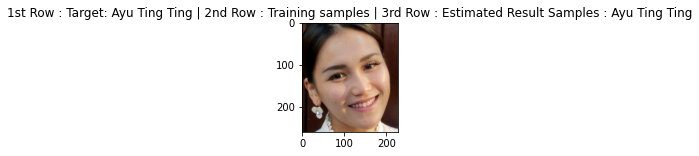

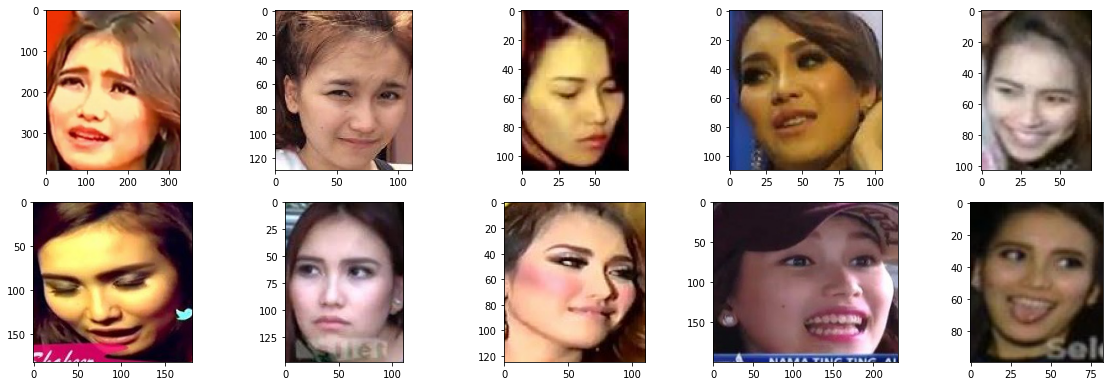

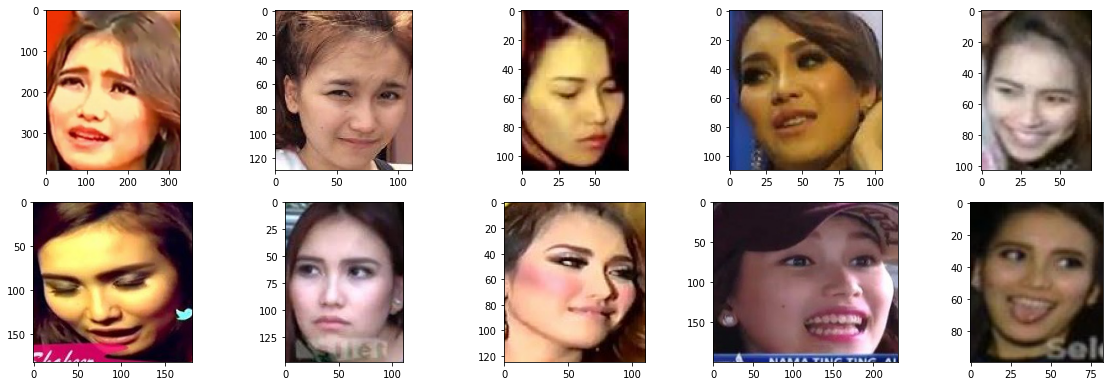

In [111]:
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from sklearn.svm import SVC
%matplotlib inline

save_path = "/hd/jbpark/IJB-C_Asian/"
embed_list = np.load(save_path+'ijbc_embed_vectors.npy')
label_list = np.load(save_path+'ijbc_labels.npy')

c_list = np.arange(30.1, 110, 10)
for c in c_list: 
    rbf_svc = SVC(kernel='rbf',C=c, gamma=0.15)
    clf = rbf_svc.fit(embed_list,label_list)


    # org_img_path = 'Test/Kelly Clarkson.jpg'
    # org_img_path = 'Test/Baby Margaretha.jpg'
    # org_img_path = 'Test/Gareth Bale.jpg' # Good
    # org_img_path = 'Test/Kelly Holmes.jpg'
    # org_img_path = 'Test/Daniele Suzuki.jpg'
    org_img_path = 'Test/Ayu Ting Ting.jpg' # Good

    img = cv2.imread(org_img_path)
    convert_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = cv2.resize(convert_img, (112,112))
    img = img.astype(np.float32) / 255.

    if len(img.shape) == 3:
        img = np.expand_dims(img, 0)

    #     print("len(img.shape): "+str(len(img.shape))+ ", img.shape = "+str(img.shape))
    embeds = l2_norm(model(img, training=False))
    result = clf.predict(embeds)
    target = subjects[np.where(label_int == result[0])[0][0]]

    plt.figure(figsize=(4,2))
    plt.title("1st Row : Target: "+org_img_path.split('/')[-1].split('.')[0] +" | 2nd Row : Training samples"+ " | 3rd Row : Estimated Result Samples : "+target)
    plt.imshow(convert_img)

    dir_base = "/hd/jbpark/IJB-C_Asian/Aligned/"
    img_dirs = glob(dir_base+org_img_path.split('/')[-1].split('.')[0]+"/*")

    images = []
    for img_path in img_dirs:
        images.append(mpimg.imread(img_path))

    plt.figure(figsize=(20,10))
    columns = 5
    for i, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.imshow(image)

    dir_base = "/hd/jbpark/IJB-C_Asian/Aligned/"
    img_dirs = glob(dir_base+target+"/*")

    images = []
    for img_path in img_dirs:
        images.append(mpimg.imread(img_path))

    plt.figure(figsize=(20,10))
    columns = 5
    for i, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.imshow(image)